# Trabajo práctico Aprendizaje Automático 1

In [1]:
#Importamos las librerias
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append("code")
current_dir = os.path.dirname(os.path.realpath('__file__'))
data_source = os.path.join(current_dir, 'data', 'weatherAUS.csv')

from cleaning.clean import Clean
from regresion_lineal.regresion import RegressionLineal
from shap_analyzer.shap_analyzer import SHAPAnalyzer
from modelo_base.regression import RegresionModelBase
from modelo_base.clasification import ClasificationModelBase
from neural_network.classification_neural import ClassificationNeuralNetwork
from neural_network.regression_neural import RegressionNeuralNetwork
from sklearn.model_selection import train_test_split


2024-02-24 20:47:40.933936: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv(data_source)
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# Análisis descriptivo

In [3]:
df.info()
# el dataset cuenta con un total de 145412 datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        145412 non-null  int64  
 1   Date              145412 non-null  object 
 2   Location          145412 non-null  object 
 3   MinTemp           143928 non-null  float64
 4   MaxTemp           144159 non-null  float64
 5   Rainfall          142152 non-null  float64
 6   Evaporation       82658 non-null   float64
 7   Sunshine          75616 non-null   float64
 8   WindGustDir       135096 non-null  object 
 9   WindGustSpeed     135159 non-null  float64
 10  WindDir9am        134850 non-null  object 
 11  WindDir3pm        141186 non-null  object 
 12  WindSpeed9am      143645 non-null  float64
 13  WindSpeed3pm      142351 non-null  float64
 14  Humidity9am       142759 non-null  float64
 15  Humidity3pm       140907 non-null  float64
 16  Pressure9am       13

In [4]:
# Filtramos por las ciudades de interés
ciudades = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']
df = df[df['Location'].isin(ciudades)]

In [5]:
# visualizamos los datos
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
30167,30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,1.0,1.0,6.0
30168,30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,1.0,1.0,6.6
30169,30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,1.0,1.0,18.8
30170,30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,1.0,1.0,77.4
30171,30180,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,1.0,1.0,1.6


In [6]:
# vemos los nombres de las columnas
df.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [7]:
# observamos la información de cada variable y si hay nulos
df.info()
"""
Contamos con un total de 15986 datos.
Tenemos 25 columnas, de las cuales 18 son variables numéricas, 1 es tipo int64 y 17 son tipo loat64. Las otras 7 son variables categóricas, tipo object.
"""

<class 'pandas.core.frame.DataFrame'>
Index: 15986 entries, 30167 to 70370
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        15986 non-null  int64  
 1   Date              15986 non-null  object 
 2   Location          15986 non-null  object 
 3   MinTemp           15495 non-null  float64
 4   MaxTemp           15500 non-null  float64
 5   Rainfall          15199 non-null  float64
 6   Evaporation       14280 non-null  float64
 7   Sunshine          14038 non-null  float64
 8   WindGustDir       14529 non-null  object 
 9   WindGustSpeed     14531 non-null  float64
 10  WindDir9am        15291 non-null  object 
 11  WindDir3pm        15696 non-null  object 
 12  WindSpeed9am      15725 non-null  float64
 13  WindSpeed3pm      15737 non-null  float64
 14  Humidity9am       15416 non-null  float64
 15  Humidity3pm       15461 non-null  float64
 16  Pressure9am       15251 non-null  float64

'\nContamos con un total de 15986 datos.\nTenemos 25 columnas, de las cuales 18 son variables numéricas, 1 es tipo int64 y 17 son tipo loat64. Las otras 7 son variables categóricas, tipo object.\n'

In [8]:
# Cantidad de valores faltantes.
df.isna().sum()

Unnamed: 0             0
Date                   0
Location               0
MinTemp              491
MaxTemp              486
Rainfall             787
Evaporation         1706
Sunshine            1948
WindGustDir         1457
WindGustSpeed       1455
WindDir9am           695
WindDir3pm           290
WindSpeed9am         261
WindSpeed3pm         249
Humidity9am          570
Humidity3pm          525
Pressure9am          735
Pressure3pm          726
Cloud9am            2677
Cloud3pm            2932
Temp9am              505
Temp3pm              496
RainToday            787
RainTomorrow         787
RainfallTomorrow     787
dtype: int64

In [9]:
# Estadística descriptiva de las variables numéricas
df.describe()

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,15986.000000,15495.000000,15500.000000,15199.000000,14280.000000,14038.000000,14531.000000,15725.000000,15737.000000,15416.000000,15461.000000,15251.000000,15260.000000,13309.000000,13054.000000,15481.000000,15490.000000,15199.000000,15199.000000,15199.000000
mean,49512.619855,11.605221,21.751781,2.303744,4.866828,6.854694,44.417315,16.613672,21.797166,68.903023,51.280577,1018.305836,1016.064239,4.750545,4.746131,15.545953,20.229154,0.234094,0.233963,2.302586
std,15172.399796,5.851347,6.053679,7.385992,3.069869,3.842419,14.958027,10.336386,9.518033,15.614788,17.721335,7.400730,7.265386,2.728329,2.589879,5.559295,5.857956,0.423445,0.423363,7.385251
min,30176.000000,-8.000000,4.100000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,11.000000,3.000000,986.700000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000,0.000000,0.000000
25%,34173.250000,7.900000,17.100000,0.000000,2.600000,3.700000,33.000000,9.000000,15.000000,59.000000,39.000000,1013.400000,1011.200000,2.000000,2.000000,11.600000,15.900000,0.000000,0.000000,0.000000
50%,47228.500000,11.600000,21.300000,0.000000,4.200000,7.500000,43.000000,15.000000,20.000000,70.000000,51.000000,1018.500000,1016.300000,6.000000,6.000000,15.400000,19.800000,0.000000,0.000000,0.000000
75%,66393.750000,15.800000,25.800000,0.800000,6.600000,10.000000,54.000000,22.000000,28.000000,80.000000,62.000000,1023.300000,1021.000000,7.000000,7.000000,19.500000,24.100000,0.000000,0.000000,0.800000
max,70391.000000,30.500000,46.800000,119.400000,23.800000,13.900000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.200000,46.100000,1.000000,1.000000,119.400000


### Analizamos nuestra variable objetivo, la que queremos predecir para saber si el df esta balanceado o no.

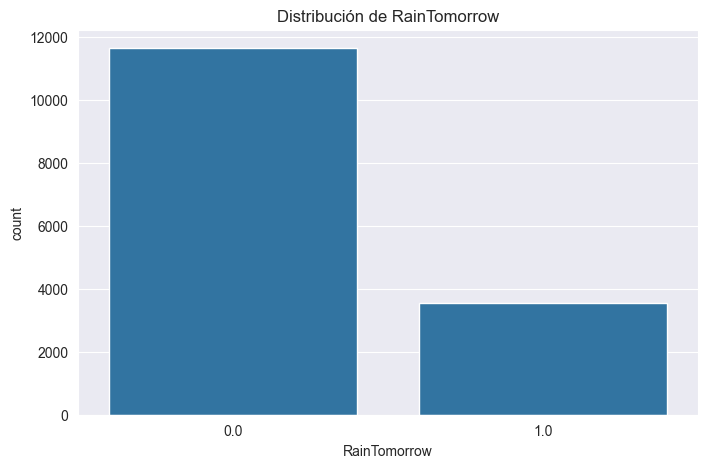

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(x='RainTomorrow', data=df)
plt.title('Distribución de RainTomorrow')
plt.show()

### Se puede observar que el dataset no esta balanceado, con esto podemos decir que nos va a predecir mejor cuando no llueve que cuando llueve

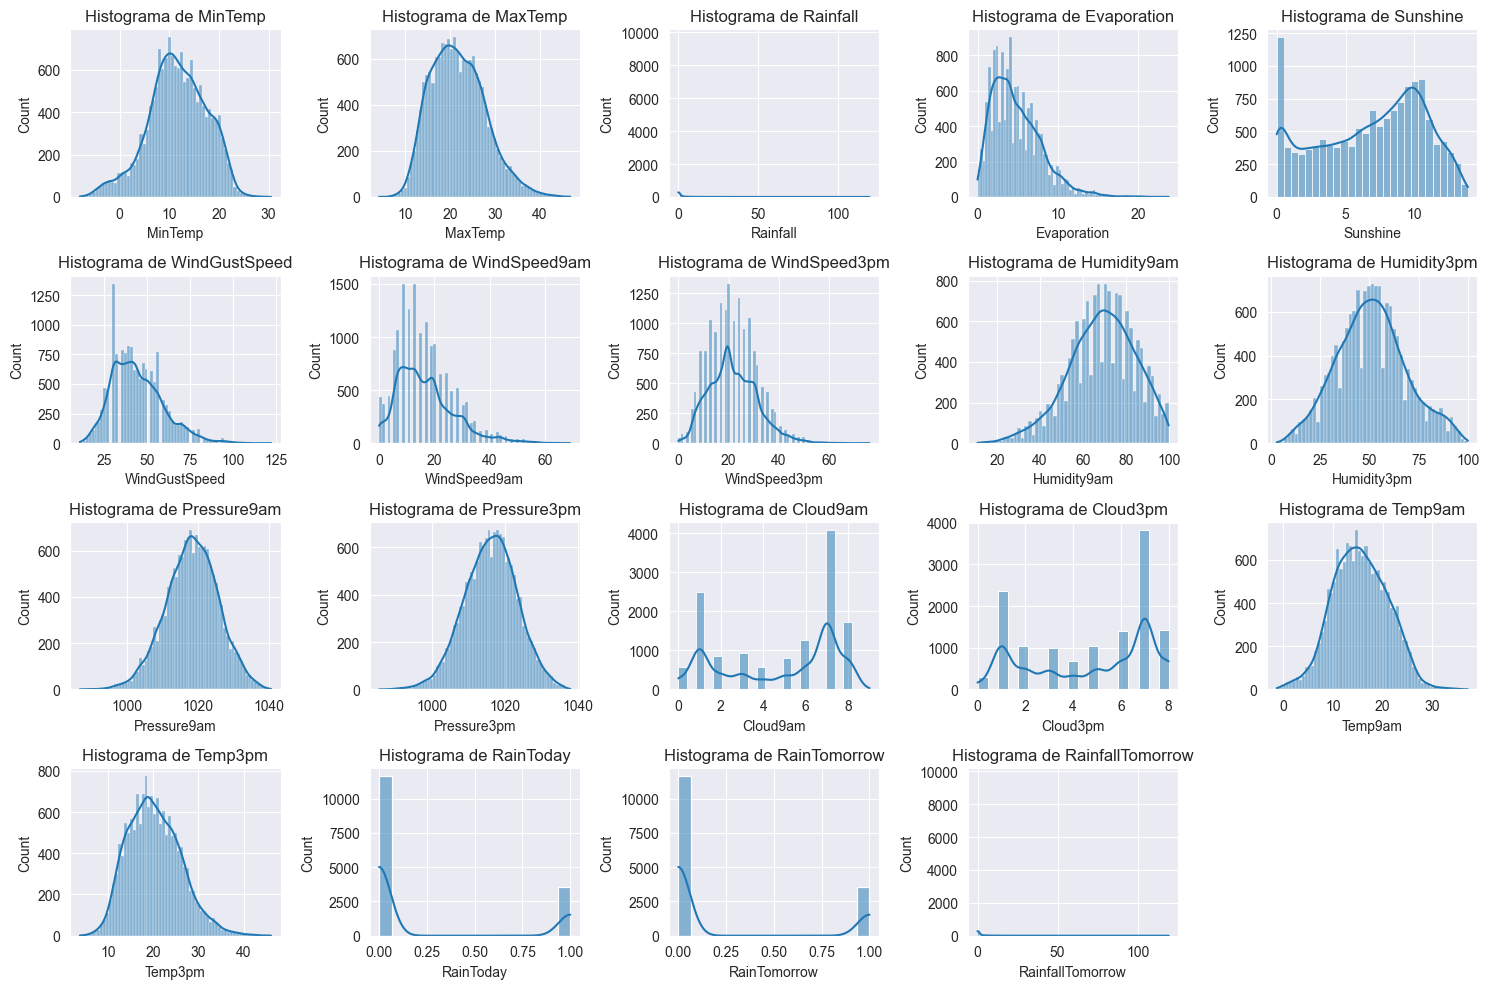

In [11]:
# Seleccionar columnas numéricas
numeric_columns = df.select_dtypes(include=[np.float64]).columns

# Realizamos histogramas de las columnas numéricas para observar su dispersión
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(f'Histograma de {column}')

plt.tight_layout()
plt.show()


Podemos observar los distintos tipos de distribución, entre ellas hay varias columnas que presentan una distribución normal

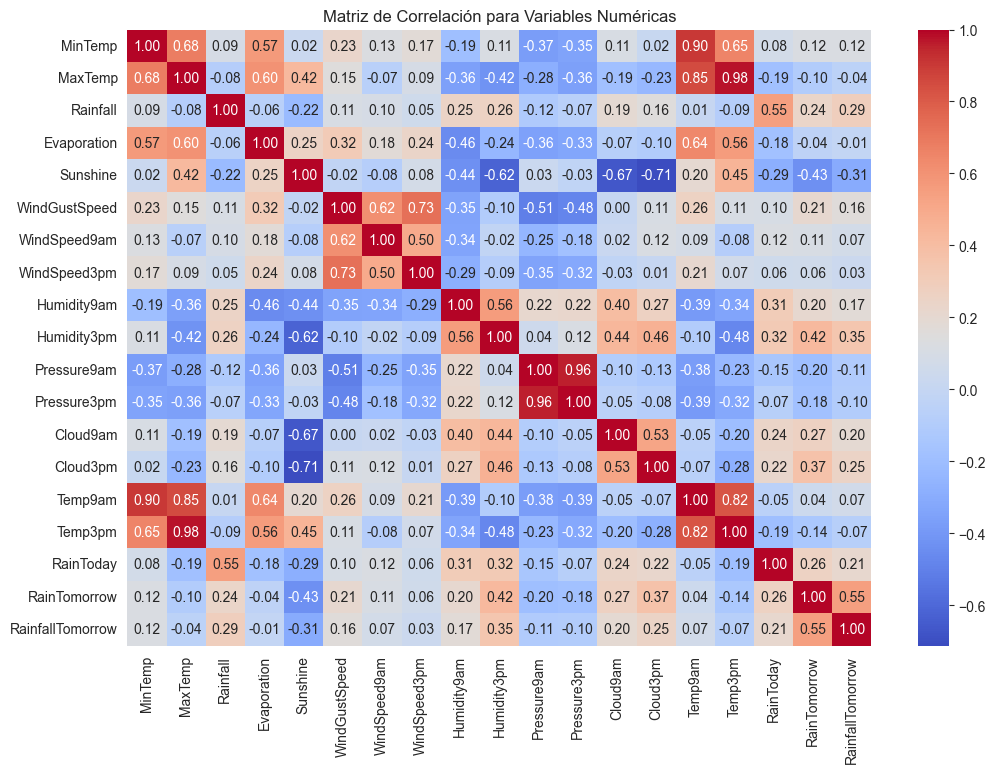

In [12]:
# Matriz de correlación para variables numéricas
correlation_matrix_numeric = df[numeric_columns].corr()

# Plotear la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación para Variables Numéricas')
plt.show()


Podemos observar que las variables con mayor correlación con RainfallTomorrow son:

*   Humidity3pm 0.35
*   Sunshine -0.31
*   Rainfall 0.29
*   Cloud3pm 0.25

## Dividimos en 2 el dataset entrenadmiento y pruebas

In [13]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

### Realizamos la limpieza en la clase clean y volvemos a visualizar los datos

In [14]:
data = Clean(train)
data_clean = data.process()
data_clean.head()

Archivo guardado exitosamente en 'data/weatherAUS_clean.csv'


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,17.6,27.8,5.2,10.2,3.6,2,13.0,13.0,66.0,49.0,1014.6,1012.8,7.0,8.0,21.4,26.3,1,1,2.2
1,2.1,12.9,0.0,2.6,8.0,4,26.0,39.0,47.0,34.0,1011.1,1011.8,3.0,1.0,10.0,10.4,0,0,0.0
2,1.2,20.7,0.0,2.6,8.0,4,4.0,35.0,78.0,46.0,1018.3,1014.7,3.0,1.0,10.0,19.6,0,0,0.0
3,12.6,18.5,8.4,2.8,3.7,4,28.0,30.0,70.0,42.0,1003.1,1005.1,8.0,7.0,15.1,16.4,1,0,0.0
4,12.7,24.8,0.0,2.8,3.7,1,6.0,9.0,73.0,76.0,1009.8,1003.2,8.0,8.0,19.2,22.7,0,1,15.8


In [15]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11684 entries, 0 to 11683
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MinTemp           11684 non-null  float64
 1   MaxTemp           11684 non-null  float64
 2   Rainfall          11684 non-null  float64
 3   Evaporation       11684 non-null  float64
 4   Sunshine          11684 non-null  float64
 5   WindGustDir       11684 non-null  int64  
 6   WindSpeed9am      11684 non-null  float64
 7   WindSpeed3pm      11684 non-null  float64
 8   Humidity9am       11684 non-null  float64
 9   Humidity3pm       11684 non-null  float64
 10  Pressure9am       11684 non-null  float64
 11  Pressure3pm       11684 non-null  float64
 12  Cloud9am          11684 non-null  float64
 13  Cloud3pm          11684 non-null  float64
 14  Temp9am           11684 non-null  float64
 15  Temp3pm           11684 non-null  float64
 16  RainToday         11684 non-null  int64 

In [16]:
data_clean.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000
mean,11.471243,21.408952,2.238959,4.518590,6.944865,2.509928,15.447278,20.999401,69.842862,51.818641,1018.851446,1016.610151,4.750257,4.721756,15.267194,19.950334,0.240500,0.225351,2.090859
std,5.561668,5.596835,7.000733,2.662924,3.772397,1.137468,8.670831,8.686879,14.389620,16.818242,6.953330,6.811566,2.718013,2.593034,5.174269,5.441019,0.427405,0.417831,6.702304
min,-3.800000,7.100000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,30.000000,7.000000,999.400000,997.600000,0.000000,0.000000,0.000000,4.300000,0.000000,0.000000,0.000000
25%,7.875000,17.100000,0.000000,2.400000,3.900000,1.000000,9.000000,15.000000,60.000000,40.000000,1014.100000,1011.900000,2.000000,2.000000,11.400000,15.900000,0.000000,0.000000,0.000000
50%,11.300000,21.100000,0.000000,4.000000,7.700000,3.000000,15.000000,20.000000,70.000000,51.000000,1018.900000,1016.700000,6.000000,6.000000,15.100000,19.600000,0.000000,0.000000,0.000000
75%,15.500000,25.300000,1.000000,6.400000,10.000000,4.000000,20.000000,28.000000,80.000000,62.000000,1023.600000,1021.300000,7.000000,7.000000,19.000000,23.800000,0.000000,0.000000,0.800000
max,26.100000,38.200000,109.400000,12.800000,13.900000,4.000000,41.000000,46.000000,100.000000,95.000000,1038.100000,1035.600000,9.000000,8.000000,30.100000,35.700000,1.000000,1.000000,109.400000


In [17]:
print(data_clean.columns)

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')


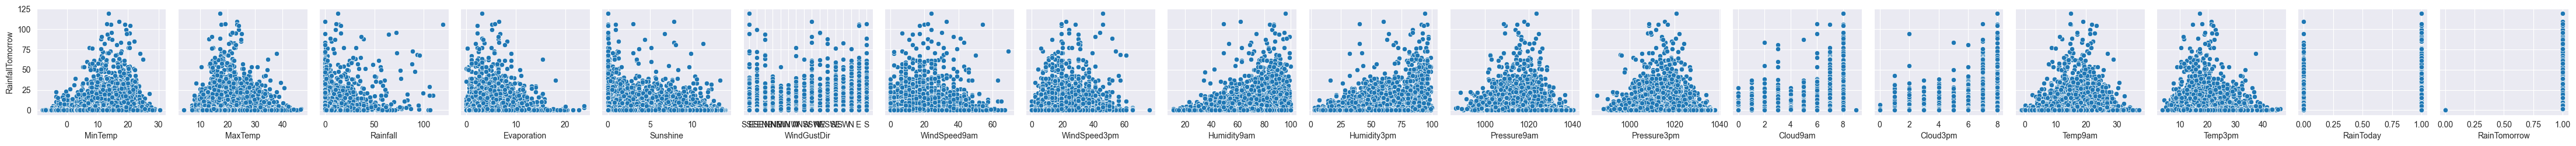

In [18]:
#Observamos la distribución para ver si hay linealidad
columnas = [col for col in data_clean.columns if ((col != 'RainfallTomorrow') & (col != 'Location') & (col != 'Date'))]

sns.pairplot(df, x_vars=columnas, y_vars='RainfallTomorrow')
plt.show()

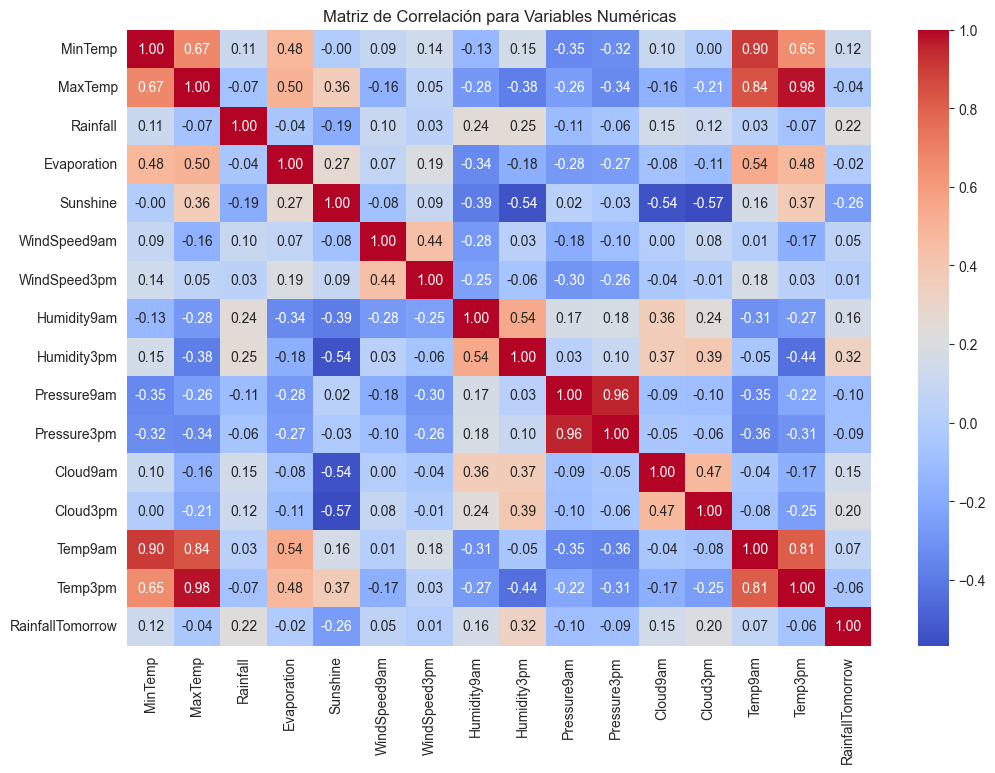

In [19]:
# Seleccionar columnas numéricas
numeric_columns = data_clean.select_dtypes(include=[np.float64, np.int32]).columns

# Matriz de correlación para variables numéricas
correlation_matrix_numeric = data_clean[numeric_columns].corr()

# Plotear la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación para Variables Numéricas')
plt.show()

### En esta parte implementamos en simultaneo las siguientes consignas:

* Implementar la solución del problema de regresión con regresión lineal múltiple.

* Optimizar la selección de hiperparámetros.

* Implementar explicabilidad del modelo. SHAP


In [20]:
regresion_clasic = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regresion_clasic.classic()
metricas = regresion_clasic.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal clasic:")
print(metricas)

       Rainfall  Humidity3pm  MinTemp  MaxTemp  Evaporation  Humidity9am  \
7144        6.8         67.0     17.6     20.9          4.6         84.0   
3065       11.2         50.0      7.4     15.8          2.6         87.0   
8883        0.0         35.0     20.8     30.0          9.2         46.0   
7817        0.0         53.0     12.5     23.5          3.6         77.0   
11066       0.0         40.0      7.6     19.7          3.4         40.0   
...         ...          ...      ...      ...          ...          ...   
10661       0.0         76.0     14.5     19.7          5.4         73.0   
3845        6.2         36.0     11.0     16.8          3.6         66.0   
6680        0.0         54.0      8.2     15.7          2.0         72.0   
1782        0.0         50.0     17.2     33.4          7.2         79.0   
4531        2.0         68.0      5.6     12.7          0.6         75.0   

       Temp9am  Temp3pm  Cloud9am  Cloud3pm  Sunshine  Pressure9am  \
7144      17.7   

In [21]:
#aplicamos validación cruzada
print(x_test)
regresion_clasic.cross_validate(x_test, y_test, modelo, cv=5)
print(f"El modelo")
print(x_test, modelo)

       Rainfall  Humidity3pm  MinTemp  MaxTemp  Evaporation  Humidity9am  \
7144        6.8         67.0     17.6     20.9          4.6         84.0   
3065       11.2         50.0      7.4     15.8          2.6         87.0   
8883        0.0         35.0     20.8     30.0          9.2         46.0   
7817        0.0         53.0     12.5     23.5          3.6         77.0   
11066       0.0         40.0      7.6     19.7          3.4         40.0   
...         ...          ...      ...      ...          ...          ...   
10661       0.0         76.0     14.5     19.7          5.4         73.0   
3845        6.2         36.0     11.0     16.8          3.6         66.0   
6680        0.0         54.0      8.2     15.7          2.0         72.0   
1782        0.0         50.0     17.2     33.4          7.2         79.0   
4531        2.0         68.0      5.6     12.7          0.6         75.0   

       Temp9am  Temp3pm  Cloud9am  Cloud3pm  Sunshine  Pressure9am  \
7144      17.7   

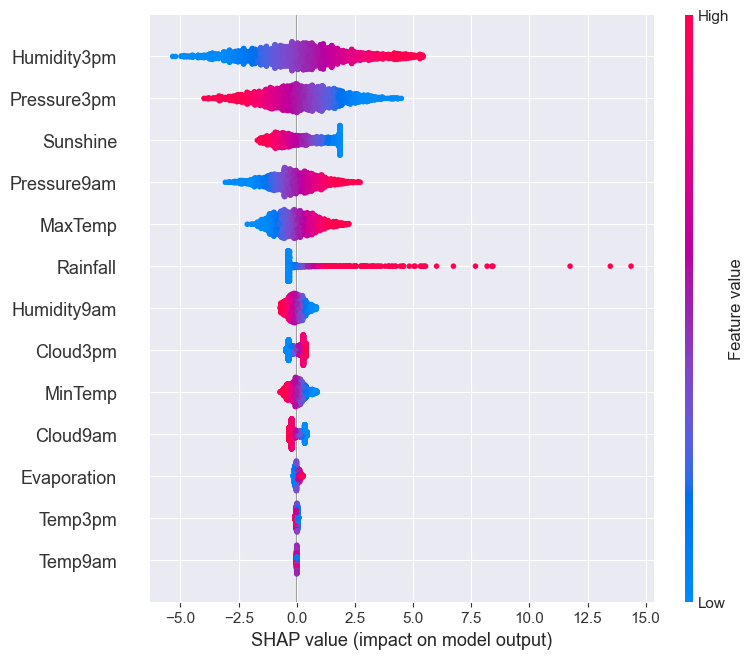

In [22]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [23]:
print('métodos de gradiente descendiente')
regresion_gradient_desecent = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regresion_gradient_desecent.gradient_descent()
metricas = regresion_gradient_desecent.metrics(y_test, y_pred)
print(f"Métricas del Modelo:")
print(metricas)

métodos de gradiente descendiente
Métricas del Modelo:
{'MSE': 1.2689441206863918e+32, 'R2': -2.411976484488477e+30, 'RMSE': 1.1264741988551676e+16, 'MAE': 1.1260572085737326e+16, 'MAPE': inf}


In [24]:
#aplicamos validación cruzada
regresion_gradient_desecent.cross_validate(x_test, y_test, modelo, cv=5)

Mean Squared Error (CV): 1.5968872084185367e+32
R^2 Score (CV): -3.03532230639324e+30
Mean Absolute Error (CV): 1.1754268559573442e+16


(1.5968872084185367e+32, -3.03532230639324e+30, 1.1754268559573442e+16)

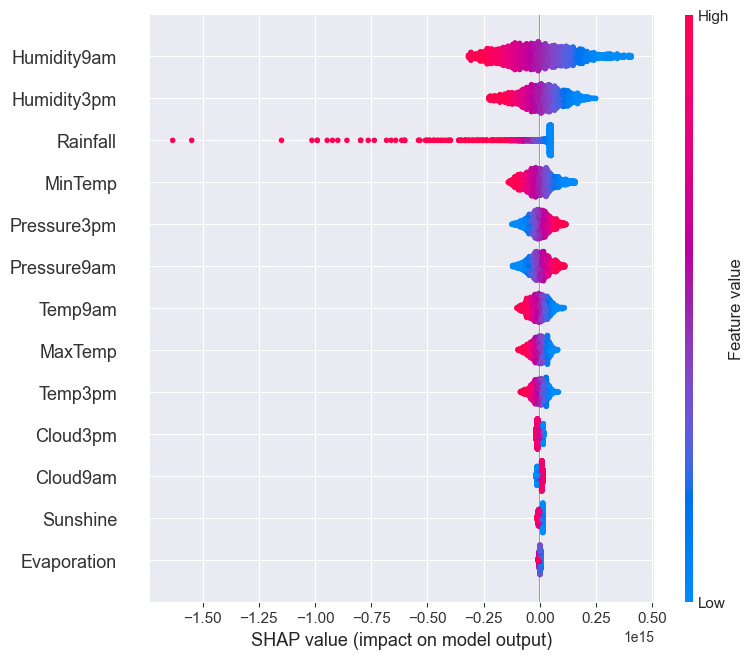

In [25]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [26]:
param_grid = {
    'fit_intercept': [True, False],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'max_iter': [100, 200, 500, 1000]  
}

regresion_gradient_descent = RegressionLineal(data_clean)
x_test, y_test, y_pred, best_model = regresion_gradient_descent.gradient_descent_optimize_hyperparameters(param_grid)
metricas = regresion_gradient_descent.metrics(y_test, y_pred)
print(f"Métricas del mejor modelo:")
print(metricas)
print("Mejores hiperparámetros:", best_model.get_params())

Métricas del mejor modelo:
{'MSE': 45.6485971483565, 'R2': 0.13232315689230667, 'RMSE': 6.756374556547061, 'MAE': 2.9831109698125875, 'MAPE': inf}
Mejores hiperparámetros: {'alpha': 0.0001, 'average': False, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'loss': 'squared_error', 'max_iter': 500, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


## Regresión linean de Lasso

In [27]:
# regresion de Lasso
regresion_lasso = RegressionLineal(data_clean)
x_test, y_test, y_pred, lasso_model = regresion_lasso.lasso_regression()
metricas = regresion_lasso.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal Lasso:")
print(metricas)

Métricas del modelo Regresion lineal Lasso:
{'MSE': 45.74799525391061, 'R2': 0.13043382315971075, 'RMSE': 6.76372643251563, 'MAE': 2.9217030577958085, 'MAPE': inf}


In [28]:
#aplicamos validación cruzada
regresion_lasso.cross_validate(x_test, y_test, modelo, cv=5)

Mean Squared Error (CV): 8.872297492411643e+31
R^2 Score (CV): -1.6864235836884205e+30
Mean Absolute Error (CV): 8178541225916724.0


(8.872297492411643e+31, -1.6864235836884205e+30, 8178541225916724.0)

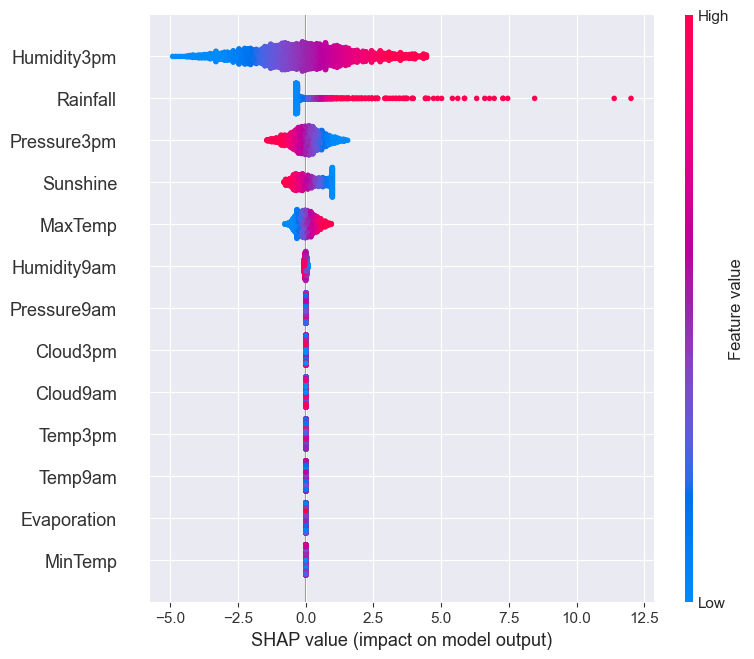

In [29]:
try:
    shap_analyzer = SHAPAnalyzer(lasso_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [30]:
# Crear una instancia de la clase RegressionLineal
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_lasso, best_lasso_model = regresion_lineal.optimize_hyperparameters('Lasso', param_grid_lasso)

# Calcular métricas
metricas_lasso = regresion_lineal.metrics(y_test, y_pred_lasso)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Lasso:")
print(metricas_lasso)
print("Mejores hiperparámetros para Lasso:", best_lasso_model.get_params())


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Métricas del mejor modelo Lasso:
{'MSE': 45.41436186868197, 'R2': 0.13677544109617645, 'RMSE': 6.7390178712244095, 'MAE': 2.940790583506835, 'MAPE': inf}
Mejores hiperparámetros para Lasso: {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


## Regresión lineal de Ridge

In [31]:
# regresion de Ridge

regresion_ridge = RegressionLineal(data_clean)
x_test, y_test, y_pred, ridge_model = regresion_ridge.ridge_regression()
metricas = regresion_lasso.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal Ridge:")
print(metricas)


Métricas del modelo Regresion lineal Ridge:
{'MSE': 45.443748401031364, 'R2': 0.1362168694157383, 'RMSE': 6.741197846156969, 'MAE': 2.9559784966830764, 'MAPE': inf}


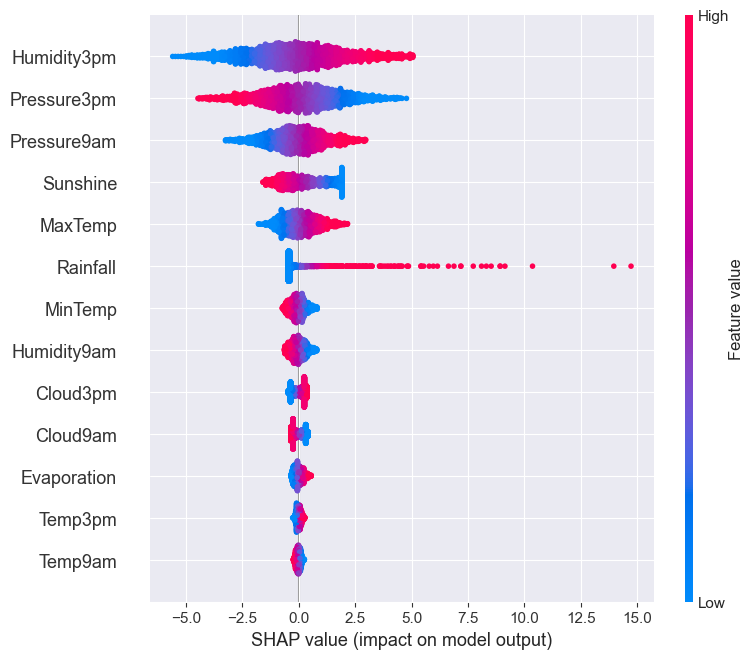

In [32]:
try:
    shap_analyzer = SHAPAnalyzer(ridge_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [33]:
# Crear una instancia de la clase RegressionLineal
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_Ridge = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_lasso, best_lasso_model = regresion_lineal.optimize_hyperparameters('Ridge', param_grid_Ridge)

# Calcular métricas
metricas_lasso = regresion_lineal.metrics(y_test, y_pred_lasso)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Ridge:")
print(metricas_lasso)
print("Mejores hiperparámetros para Ridge:", best_lasso_model.get_params())

Métricas del mejor modelo Ridge:
{'MSE': 45.4429716325494, 'R2': 0.13623163403209804, 'RMSE': 6.741140232375336, 'MAE': 2.9557353114107796, 'MAPE': inf}
Mejores hiperparámetros para Ridge: {'alpha': 100.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


## Regresión lineal de Elasticnet

In [34]:
# regresion de Elasticnet

regresion_elasticnet = RegressionLineal(data_clean)
x_test, y_test, y_pred, elasticnet_model = regresion_elasticnet.elasticnet_regression()

metricas = regresion_elasticnet.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal Elasticnet:")
print(metricas)

Métricas del modelo Regresion lineal Elasticnet:
{'MSE': 45.62121997541179, 'R2': 0.13284353518381642, 'RMSE': 6.754348227283798, 'MAE': 2.92961768381024, 'MAPE': inf}


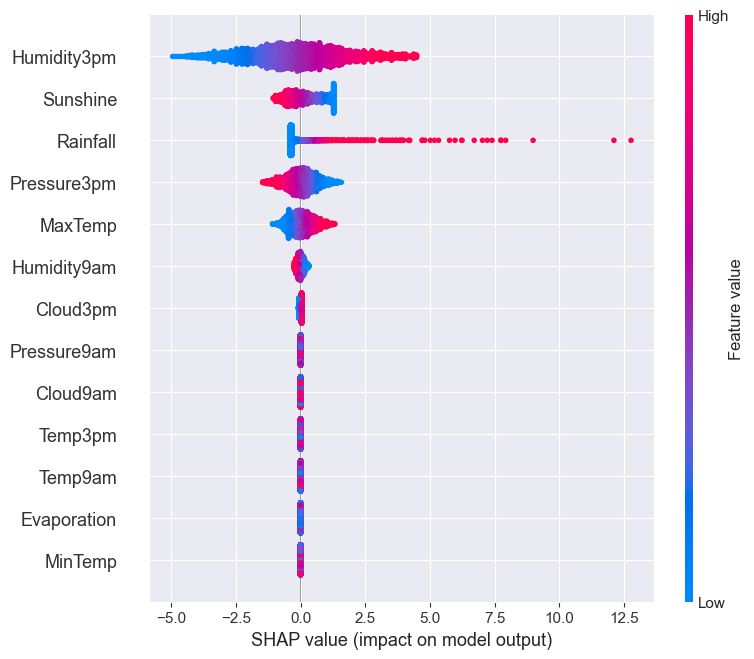

In [35]:
try:
    shap_analyzer = SHAPAnalyzer(elasticnet_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [36]:
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_Elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Puedes ajustar estos valores según sea necesario
}
# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_elasticnet, best_lasso_model = regresion_lineal.optimize_hyperparameters('ElasticNet', param_grid_Elasticnet)

# Calcular métricas
metricas_elasticnet = regresion_lineal.metrics(y_test, y_pred_elasticnet)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Elasticnet:")
print(metricas_elasticnet)
print("Mejores hiperparámetros para Elasticnet:", best_lasso_model.get_params())

Métricas del mejor modelo Elasticnet:
{'MSE': 45.42379433166565, 'R2': 0.13659615125561886, 'RMSE': 6.739717674477593, 'MAE': 2.9489246857996543, 'MAPE': inf}
Mejores hiperparámetros para Elasticnet: {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.3, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


## Regresión Logística

Accuracy: 0.84
Precision: 0.74
Recall: 0.45
F1 Score: 0.56
ROC-AUC: 0.70
Matiz de confusión:
          pred: No  Pred: Si
Real: No      1724        83
Real: si       293       237


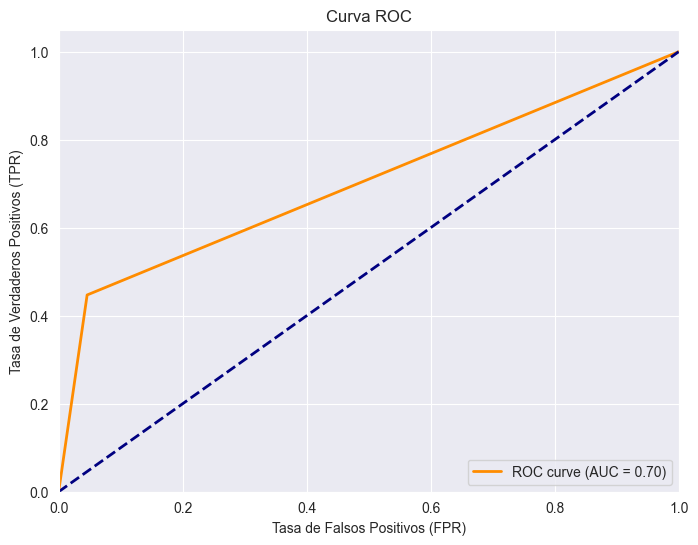

In [37]:
#regresion logistica
regression_logistic = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regression_logistic.logistic()
regression_logistic.logic_metrics(y_test, y_pred)

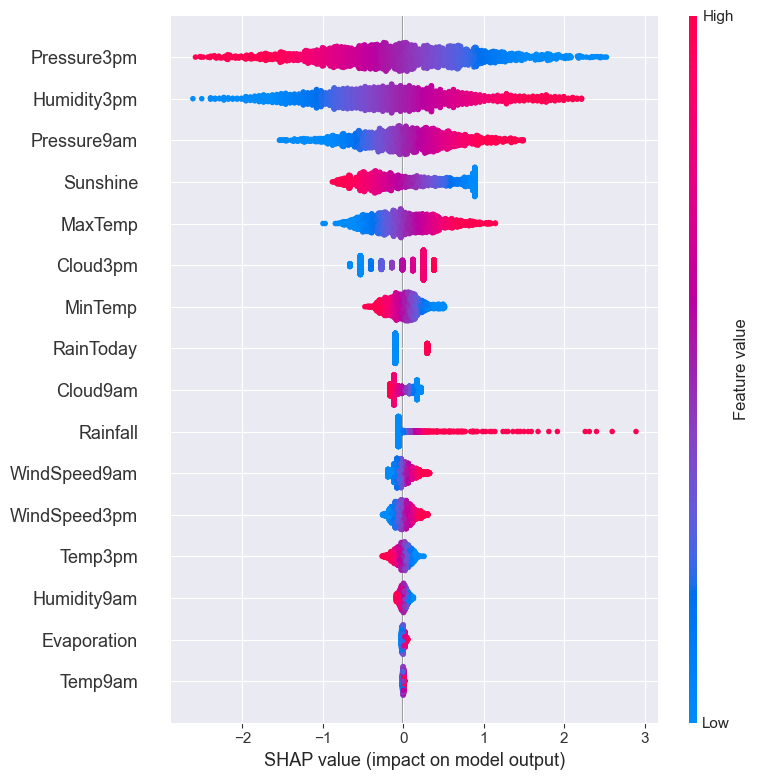

In [38]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [ ]:
regresion_lineal = RegressionLineal(data_clean)
#buscando los hipperparametros
param_grid_logistic = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
x_test_logistic, y_test_logistic, y_pred_logistic, best_logistic_model = regresion_lineal.optimize_hyperparameters_logistic(param_grid_logistic)

# Calcular métricas
metricas_logistic = regresion_lineal.metrics(y_test_logistic, y_pred_logistic)

# Imprimir métricas y mejores hiperparámetros para la regresión logística
print(f"Métricas del mejor modelo de regresión logística:")
print(metricas_logistic)
print("Mejores hiperparámetros para la regresión logística:", best_logistic_model.get_params())


### Observamos que tanto el modelo como la validación cruzada tienden a sobreajustar las predicciones hacia la clase negativa. Esto se debe a que la clase negativa es la más predominante. Para abordar este desbalance, procedemos a equilibrar las clases.

In [ ]:
#regresion logistica balanceada
regression_logistic = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regression_logistic.logistic_balanced()
regression_logistic.logic_metrics(y_test, y_pred)

### Optamos por mantener el modelo balanceado, ya que aunque observamos una disminución en las métricas de predicción negativa, consideramos prioritario mejorar las métricas de predicción positiva. En este contexto, valoramos una mayor precisión en la anticipación de días lluviosos.

## Implementar un modelo base para clasificación y uno para regresión

In [ ]:
#modelo base
regresion_model = RegresionModelBase(data_clean)
x_test, y_test, y_pred, modelo = regresion_model.regresion()
# También puedes acceder a los atributos del mejor modelo obtenido
print("Mejores hiperparámetros encontrados mediante Grid Search:")
print(modelo.get_params())

In [ ]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [ ]:
#clasificador Base
clasification_model = ClasificationModelBase(data_clean)
# Entrenar el modelo y obtener los resultados
x_test, y_test, predictions, best_model = clasification_model.clasificacion()
print("Mejores hiperparámetros encontrados mediante Grid Search:")
print(best_model.get_params())

In [ ]:
try:
    shap_analyzer = SHAPAnalyzer(best_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

## Implementar las soluciones con una red neuronal

In [ ]:
print('=============================clasificacion con redes neuronales================================================')
classification_nn_model = ClassificationNeuralNetwork(data_clean)
trained_model = classification_nn_model.classification()


In [ ]:
regression_nn_model = RegressionNeuralNetwork(data_clean)
regression_nn_model.regression()